In [1]:
!pip install feature_engine
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, gc, joblib, re
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, chi2, RFE, SequentialFeatureSelector
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

In [2]:
# Load the dataset
data = pd.read_csv("D:/OneDrive/Documents/mokha.csv")
df = data.copy()

         Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                        6819.000000          
mean      0.032263                                           0.505180          
std       0.176710                                           0.060686          
min       0.000000                                           0.000000          
25%       0.000000                                           0.476527          
50%       0.000000                                           0.502706          
75%       0.000000                                           0.535563          
max       1.000000                                           1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                          

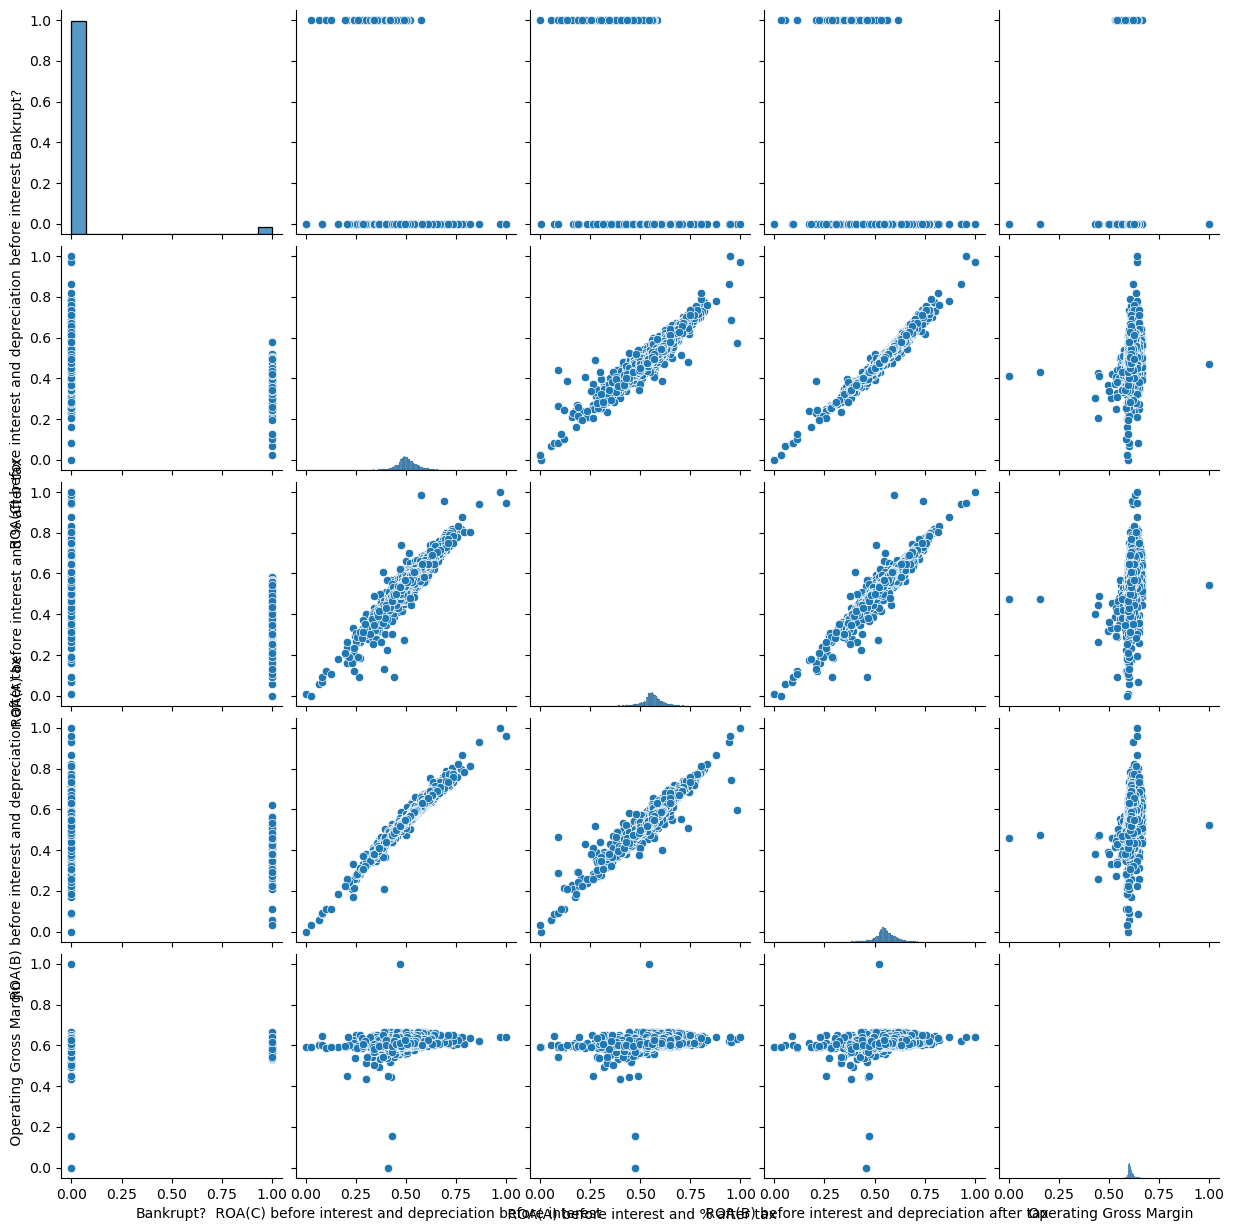

In [3]:
# Preliminary data analysis
print(df.describe())
sns.pairplot(df.iloc[:, :5])  # Visualizing first few features
plt.show()

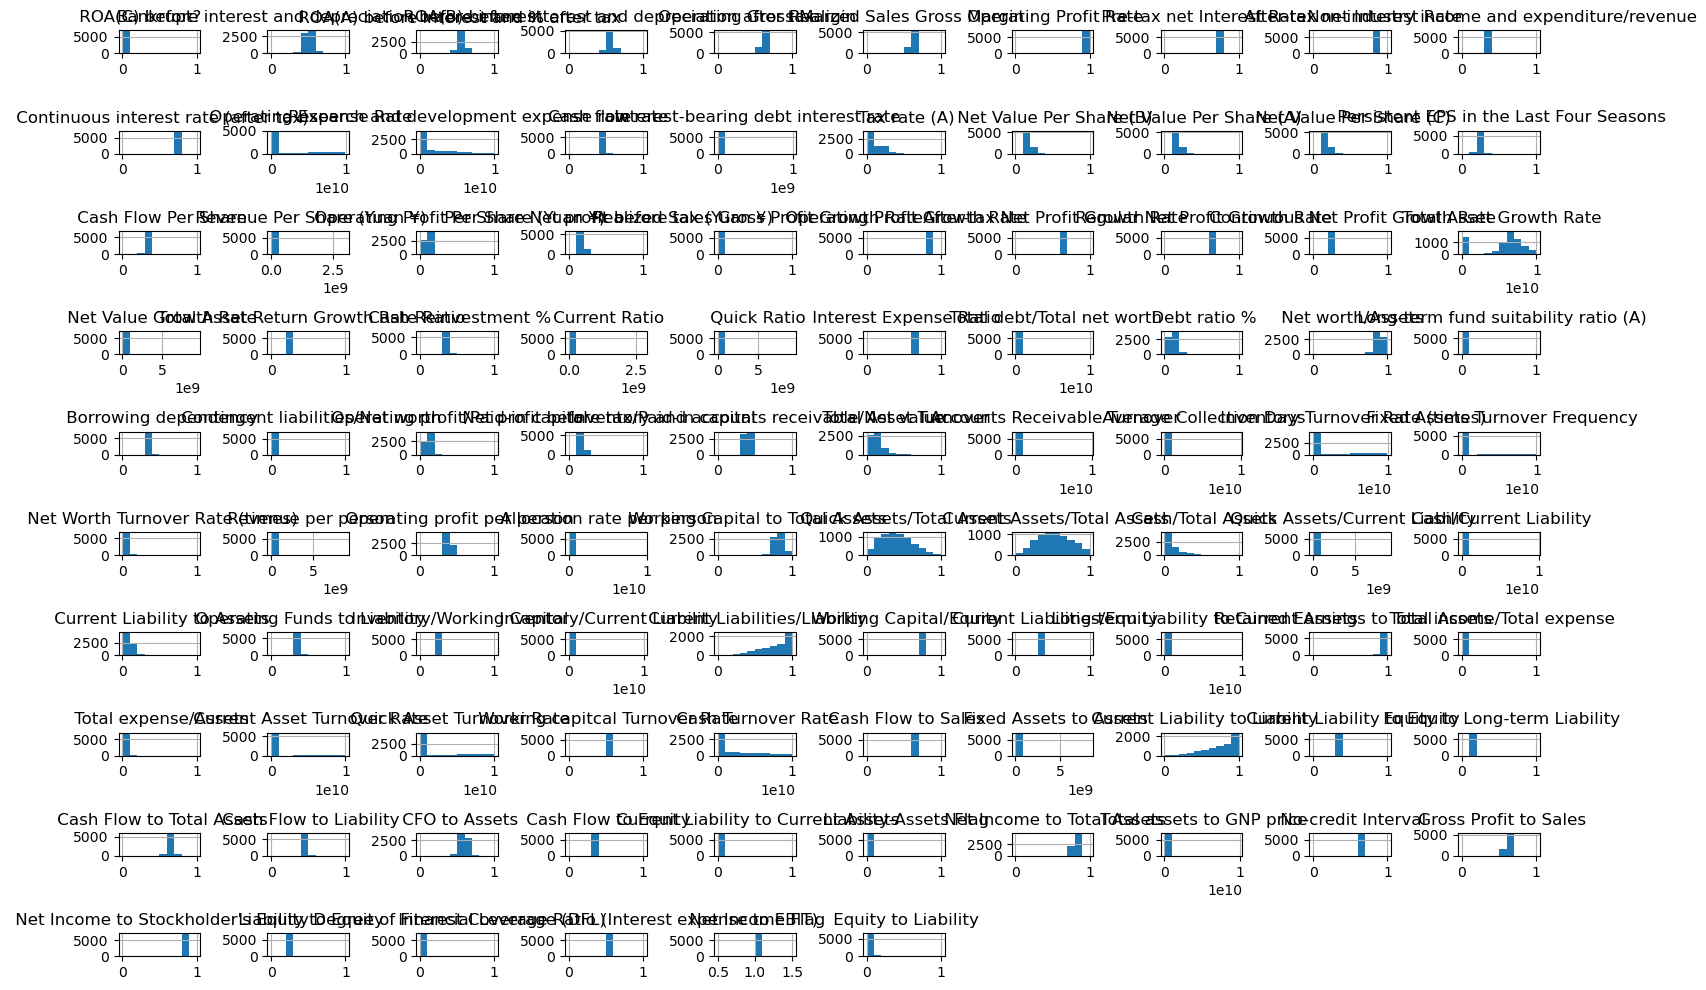

In [4]:
# Basic statistics and histograms for understanding distributions
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

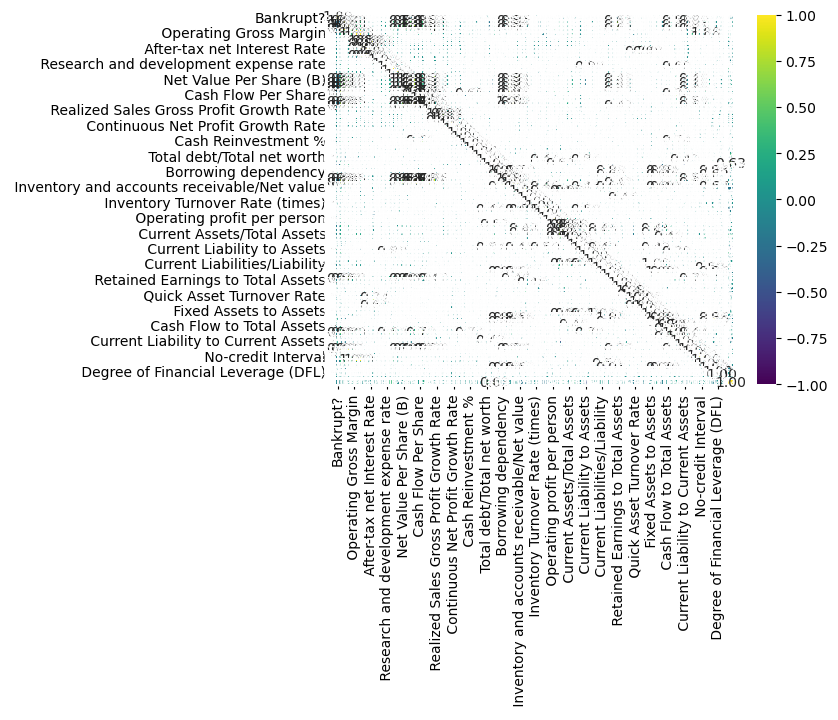

In [5]:
# Correlation matrix for feature relationships
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.show()

In [18]:
X = pipeline.fit_transform(df.drop('Bankrupt?', axis=1))
y = df['Bankrupt?']

In [19]:
# Preprocessing: Removing constant, correlated, and duplicate features
pipeline = Pipeline(steps=[
    ('constant', DropConstantFeatures()),
    ('correlated', DropCorrelatedFeatures()),
    ('duplicate', DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(6819, 69)

In [21]:
# Handling imbalanced dataset using SMOTE
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({1: 6599, 0: 6599})


In [25]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [26]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95, random_state=7)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [28]:
# Model Training with Hyperparameter Tuning
# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [29]:
# Randomized search on hyper parameters for Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train_pca, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [30]:
# Hyperparameter grid for Logistic Regression
log_param_grid = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter
    'penalty': ['l1', 'l2'],     # Norm used in penalization
    'solver': ['liblinear']      # Algorithm to use for optimization (liblinear works well with l1 and l2)
}

# Logistic Regression model
log_reg = LogisticRegression()

# Grid search on hyper parameters for Logistic Regression
log_grid_search = GridSearchCV(estimator=log_reg, param_grid=log_param_grid, cv=3, verbose=2, n_jobs=-1)
log_grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=2)

In [31]:
# Ensemble Model: Voting Classifier with Logistic Regression and Random Forest
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf_model)], 
    voting='soft'
)
voting_clf.fit(X_train_pca, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [32]:
# Model Evaluation
for clf in (log_reg, rf_model, voting_clf):
    clf.fit(X_train_pca, y_train)
    y_pred = SSclf.predict(X_test_pca)
    print(f"Model: {clf.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred)}\n")

Model: LogisticRegression
Accuracy: 0.9253787878787879
Precision: 0.901932712956335
Recall: 0.9545454545454546
F1 Score: 0.9274935590725065
ROC-AUC: 0.9253787878787879

Model: RandomForestClassifier
Accuracy: 0.9821969696969697
Precision: 0.9782118707738543
Recall: 0.9863636363636363
F1 Score: 0.982270841192003
ROC-AUC: 0.9821969696969697

Model: VotingClassifier
Accuracy: 0.9590909090909091
Precision: 0.9372294372294372
Recall: 0.9840909090909091
F1 Score: 0.9600886917960089
ROC-AUC: 0.9590909090909091

